In [1538]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime

In [1539]:
df = pd.read_csv("../data/Ana_Health-Tabela_Modelo_Previsao_Churn.csv",skiprows=1)

# Criando dataframe com os dados com ocorrência única de won ou lost

In [1540]:
colunas = ['id_person','state', 'city', 'postal_code', 'id_person_recommendation', 'Recebe Comunicados?', 'Interesses', 'Pontos de Atenção',
           'id_stage', 'id_org', 'status.1', 'activities_count', 'Qde Todos Atendimentos', 'Faltas Todos Atendimento', 'Datas Atendimento Médico',
           'Datas Acolhimento', 'Datas Psicoterapia','Qde Prescrições', 'Datas Prescrição', 'Qde Respostas WHOQOL']

df = df.drop(colunas, axis=1)

### Transformando a coluna de 'status' em apenas o último status

In [1541]:
# def lastStatus(x):
#     if pd.isnull(x):
#         return 'none'
#     s = x.split(';')
#     return s[-1].strip()

# df['status'] = df['status'].apply(lastStatus)
def lastStatus(x):
    s = x.split(';')
    return s[-1].strip()

df['status'] = df['status'].dropna().apply(lastStatus)

In [1542]:
df['status'].value_counts()

status
won     586
lost    492
Name: count, dtype: int64


Se o cliente tiver mais de um start of service é considerado o primeiro

In [1543]:
def first_date(x):
    if pd.isnull(x):
        return x
    s = x.split(';')
    return s[0].strip()


df['start_of_service'] = df['start_of_service'].apply(first_date)



Se o cliente tiver com status won e lost_reason é para eliminar o lost_reason
Se estiver com status lost é considerado o último lost_reason

In [1544]:
def lost_reason_lost(x,y):
    if pd.isnull(x) or pd.isnull(y):
        return None
    
    if x == 'won':
        return None
    
    s = y.split(';')
    return s[-1].strip()

In [1545]:
df['lost_reason'] = df.apply(lambda row: lost_reason_lost(row['status'], row['lost_reason']), axis=1)
df['lost_reason'].value_counts()

lost_reason
[Assinatura] Desligamento                                                                   221
[Assinatura] Não quer seguir com a Ana                                                       64
[Assinatura] Empresa cancelou o benefício da Ana                                             55
[Assinatura] Precisou cortar custos                                                          28
[Assinatura] Cancelamento por inadimplência                                                  26
[Assinatura] Está sem tempo para conciliar os atendimentos                                   23
[Assinatura] Cancelamento após saída da psicoterapeuta do time da Ana                        11
[Assinatura] Não estava sentindo evolução na psicoterapia                                     7
[Assinatura] Final do Piloto                                                                  5
[Assinatura] Desengajou após sentir melhora das questões que a levaram para psicoterapia      5
[Assinatura] Recebeu um bene

In [1546]:
def devolve_media(x):
    if pd.isnull(x):
        return None
    x = x.replace(',','.')
    s = x.split(';')
    s = [float(i) for i in s]
    return np.mean(s)

In [1547]:
colunas_whoqol = ['Físico', 'Psicológico', 'Social', 'Ambiental']
for coluna in colunas_whoqol:
    df[coluna] = df[coluna].apply(devolve_media)

In [1548]:
df['Físico'].describe()

count    898.000000
mean       3.645049
std        0.657525
min        1.300000
25%        3.300000
50%        3.700000
75%        4.100000
max        5.000000
Name: Físico, dtype: float64

Transformando datas em datetime

In [1549]:
colunas_de_data = ['contract_start_date', 'start_of_service', 'lost_time', 'add_time', 'won_time', 'lost_time.1']
colunas_seg = ['stay_in_pipeline_stages_welcome','stay_in_pipeline_stages_first_meeting', 'stay_in_pipeline_stages_whoqol']

for coluna in colunas_seg:
    df[coluna+'_h'] = df[coluna]/3600

df = df.drop(colunas_seg, axis=1)

#Trocar a data pelo tempo em dias ate o dia de hoje
for coluna in colunas_de_data:
    df[coluna] = pd.to_datetime(df[coluna], errors='coerce')
    df[coluna] = df[coluna].apply(lambda x: (datetime.now() - x).days)




In [1550]:
df['Problemas Abertos'].head(200)

0                                        NaN
1                                        NaN
2                                        NaN
3                                        NaN
4                                        NaN
                       ...                  
195    infecção por coronavírus A77 (CIAP-2)
196         dor articular do pé L17 (CIAP-2)
197                                      NaN
198                                      NaN
199                                      NaN
Name: Problemas Abertos, Length: 200, dtype: object

In [1551]:
def tem_ou_nao(x):
    if pd.isnull(x) :
        return 0
    return 1

df['Problemas Abertos'] = df['Problemas Abertos'].apply(tem_ou_nao)

In [1552]:
df['Problemas Abertos'].describe()


count    1201.000000
mean        0.507910
std         0.500146
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Problemas Abertos, dtype: float64

### Criando o dataframe com apenas as linhas que tem valor de status igual a won ou lost.

In [1553]:
df_simple = df[df['status'].isin(['won', 'lost'])]

### Aplicando os filtros de status igual a won e data de fim de contrato igual a NaN. Além do filtro de status igual a lost e com data de fim de contrato 

In [1554]:
f1 = df_simple[(df_simple['status'] == 'won') & (df_simple['contract_end_date'].isna())] 
f2 = df_simple[(df_simple['status'] == 'lost') & (df_simple['contract_end_date'].notna())] 

df_simple = pd.concat([f1, f2])

<Axes: xlabel='contract_end_date'>

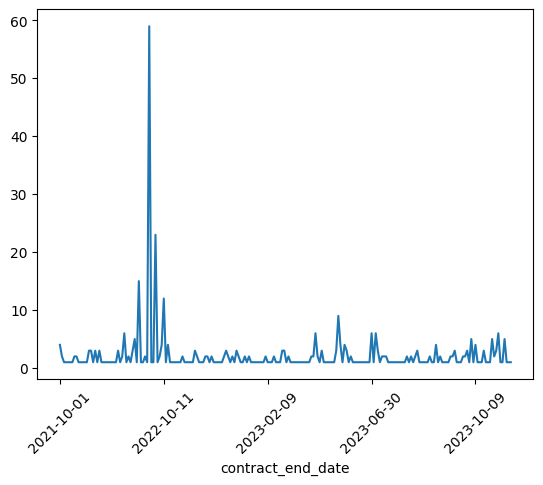

In [1555]:
df_simple.groupby('contract_end_date')['status'].count().sort_index().rolling(1).sum().plot(rot=45)

### Mudando a coluna de data de começo de contrato para formato de data do pandas

In [1556]:
df_simple['contract_start_date'] = pd.to_datetime(df_simple['contract_start_date'])
df_simple = df_simple.sort_values(by=['contract_start_date'])

In [1557]:
df_simple['status'].value_counts()

status
won     574
lost    471
Name: count, dtype: int64

In [1558]:
# #Dado um intervalo de tempo, criar analises de churn baseado na saúde da empresa
# #Criar um modelo de previsão de churn
# # saintes, entrantes, médias de pagamentos, std.pagamentos. Qde Total de Tentativas de Cobrança, Qde Total de Faturas

# df_filtered = df_simple[df_simple['contract_start_date'].between('2021-01-01', '2021-12-31')]
# df_filtered

# #novo dataframe com as colunas que serão usadas no modelo

# new_df = pd.DataFrame(columns=['saintes', 'entrantes', 'media_pagamentos', 'std_pagamentos', 'qde_total_tentativas_cobranca', 'qde_total_faturas', 'churn'])

# #atribuir valores ao novo dataframe

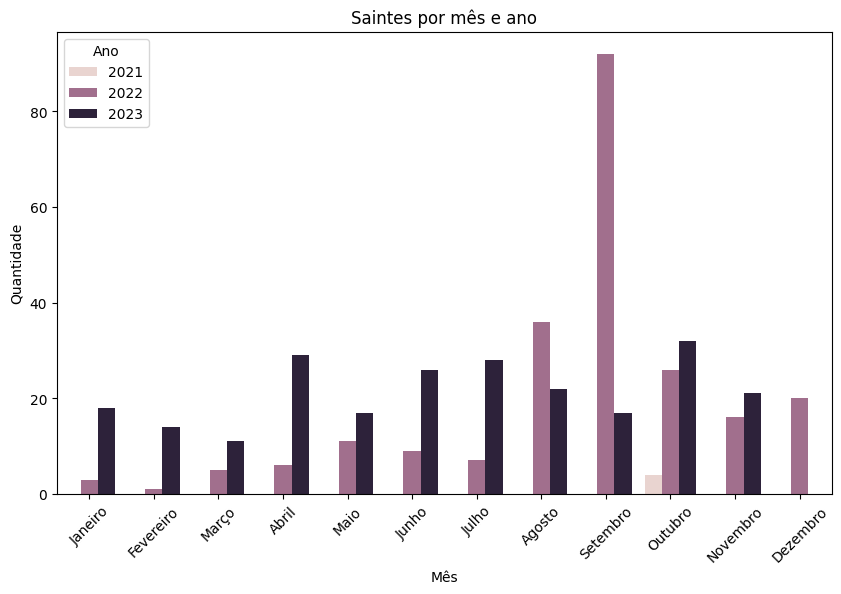

In [1559]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # Make sure to import pandas if not already done

# Assuming df_simple is your DataFrame

# Convert 'contract_end_date' to datetime if not already in that format
df_simple['contract_end_date'] = pd.to_datetime(df_simple['contract_end_date'])

nome_dos_meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

coluna = 'contract_end_date'
new_name = coluna + '_year'
df_simple[new_name] = df_simple[coluna].dt.year

# Plotar gráfico de barras separado por ano
plt.figure(figsize=(10, 6))  # Definir tamanho da figura
# Usar seaborn para criar facetas
sns.countplot(x=df_simple[coluna].dt.month, hue=df_simple[new_name])
plt.title('Saintes por mês e ano')  # <- Fix the line ending
# Rotacionar labels do eixo x
plt.xticks(rotation=45)
# Alterar labels do eixo x
plt.xticks(np.arange(12), nome_dos_meses)
# Trocar legenda da coluna
plt.legend(title='Ano', loc='upper left', labels=['2021', '2022', '2023'])
# Trocar nome do eixo x
plt.xlabel('Mês')
# Trocar nome do eixo y
plt.ylabel('Quantidade')
plt.show()


In [1560]:
colunas_de_data = ['contract_end_date']

# LEmbrar de colocar a 'contract_end_date' para time delta posteriormente

#Trocar a data pelo tempo em dias ate o dia de hoje
for coluna in colunas_de_data:
    df[coluna] = pd.to_datetime(df[coluna], errors='coerce')
    df[coluna] = df[coluna].apply(lambda x: (datetime.now() - x).days)




In [1561]:
def ultima_mensagem(x,y):
    if (y == None):
        return "Cliente"
    
    if x>y:
        return "Cliente"
    
    else:
        return "Empresa"

In [1562]:
df_aux = df_simple[df_simple['Data Última Mensagens Inbound'].notnull()]
df_aux['Data Última Mensagens Inbound'] = pd.to_datetime(df_aux['Data Última Mensagens Inbound'])
df_aux['Data Última Mensagens Outbound'] = pd.to_datetime(df_aux['Data Última Mensagens Outbound'])
df_aux['Tempo Última Mensagem Inbound'] = df_aux['Data Última Mensagens Inbound'].apply(lambda x: (datetime.now() - x).days)
df_aux['Tempo Última Mensagem Outbound'] = df_aux['Data Última Mensagens Outbound'].apply(lambda x: (datetime.now() - x).days)

df_aux['Quem Enviou Última Mensagem'] = df_aux.apply(lambda row: ultima_mensagem(row['Tempo Última Mensagem Inbound'], row['Tempo Última Mensagem Outbound']), axis=1)


C:\Users\erikb\AppData\Local\Temp\ipykernel_27284\4269974155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Data Última Mensagens Inbound'] = pd.to_datetime(df_aux['Data Última Mensagens Inbound'])
C:\Users\erikb\AppData\Local\Temp\ipykernel_27284\4269974155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Data Última Mensagens Outbound'] = pd.to_datetime(df_aux['Data Última Mensagens Outbound'])
C:\Users\erikb\AppData\Local\Temp\ipykernel_27284\4269974155.py:4: SettingWithCopyWarnin

In [1563]:
df_aux['Quem Enviou Última Mensagem'].value_counts()
df_aux['Status Assinatura'] = df_aux['status'].apply(lambda x: "Ativa" if x == "won" else "Inativa")


C:\Users\erikb\AppData\Local\Temp\ipykernel_27284\3194983688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Status Assinatura'] = df_aux['status'].apply(lambda x: "Ativa" if x == "won" else "Inativa")


<Axes: title={'center': 'Status dos Usuários em Relação a Última Mensagema'}, xlabel='Status Assinatura', ylabel='Quantidade Usuários'>

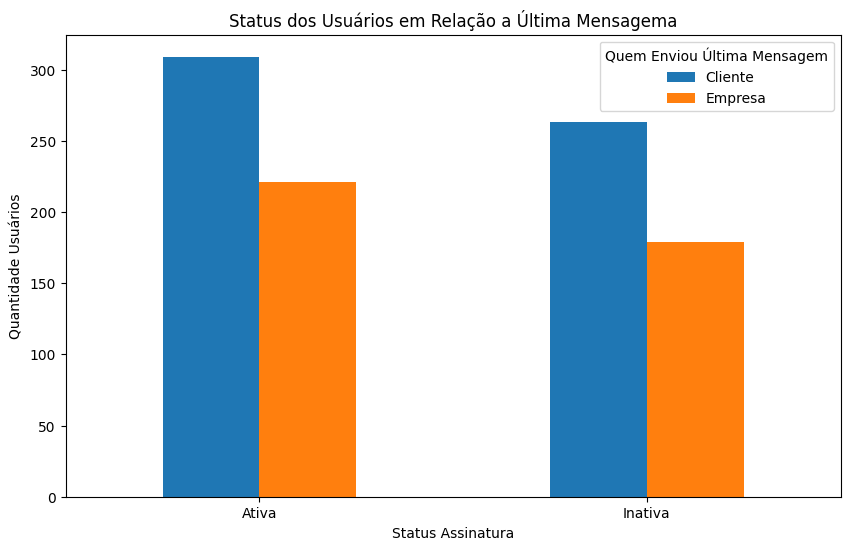

In [1564]:
df_aux.groupby('Status Assinatura')['Quem Enviou Última Mensagem'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Quantidade Usuários', title='Status dos Usuários em Relação a Última Mensagema', figsize=(10,6))


<Axes: title={'center': 'Quem enviou a última mensagem X Status do Cliente'}, xlabel='Status da Assinatura do Cliente', ylabel='Quantidade de Conversas'>

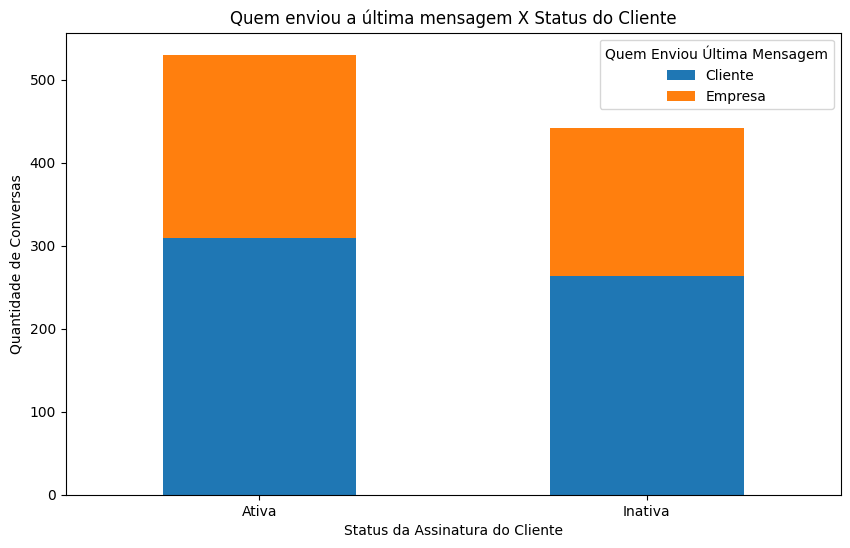

In [1565]:
df_aux.groupby('Status Assinatura')['Quem Enviou Última Mensagem'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Quantidade de Conversas', xlabel="Status da Assinatura do Cliente", title='Quem enviou a última mensagem X Status do Cliente', stacked=True, figsize=(10,6))


<Axes: title={'center': 'Quem enviou a última mensagem X Status do Cliente'}, xlabel='Status da Assinatura do Cliente', ylabel='Quantidade de Conversas'>

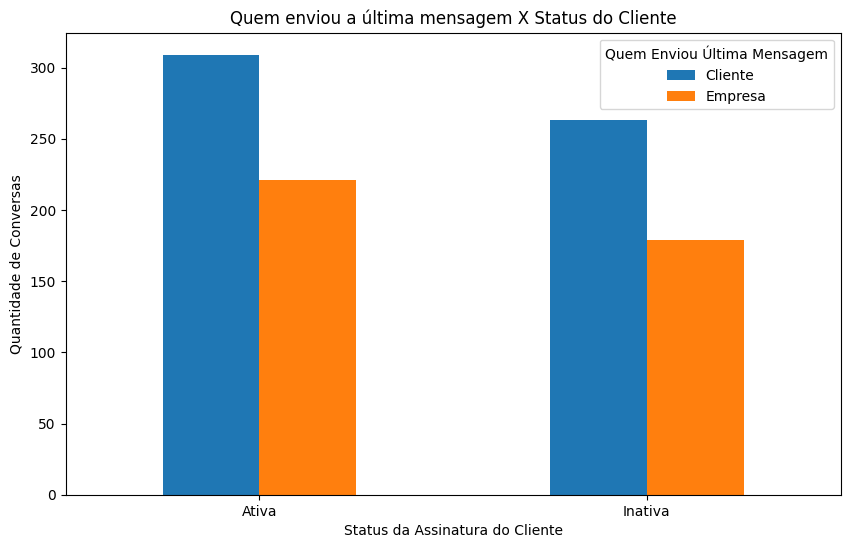

In [1566]:
df_aux.groupby('Status Assinatura')['Quem Enviou Última Mensagem'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Quantidade de Conversas', xlabel="Status da Assinatura do Cliente", title='Quem enviou a última mensagem X Status do Cliente', figsize=(10,6))


In [1567]:
df2 = pd.read_csv('vamo_ver.csv')
df2 = df2.drop(['Unnamed: 0'], axis=1)


df2['status'].value_counts()

status
won     568
lost    464
Name: count, dtype: int64

In [1568]:
df2.head()

,id_person,birthdate,id_gender,id_marrital_status,id_health_plan,contract_start_date,contract_end_date,id_continuity_pf,Canal de Preferência,notes_count,...,Qde Total de Tentativas de Cobrança,Método de Pagamento,Valor Médio da Mensalidade,Qde Total de Faturas Pagas após Vencimento,Qde Total de Faturas Inadimpletes,Valor Total Inadimplência,Qde Perfis de Pagamento Inativos,Tempo Última Mensagem Inbound,Tempo Última Mensagem Outbound,Quem Enviou Última Mensagem
0,5956,38.0,63.0,82.0,NaN,1970-01-01 00:00:00.000000019,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,Empresa
1,5954,53.0,63.0,82.0,NaN,1970-01-01 00:00:00.000000020,NaN,NaN,239.0,0,...,1.0,Cartão de crédito,120.0,0.0,0.0,0.0,False,NaN,NaN,Empresa
2,5949,26.0,64.0,80.0,NaN,1970-01-01 00:00:00.000000020,NaN,NaN,239.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,Empresa
3,5948,33.0,64.0,80.0,NaN,1970-01-01 00:00:00.000000020,NaN,NaN,NaN,0,...,1.0,Cartão de crédito,50.0,0.0,0.0,0.0,False,NaN,NaN,Empresa
4,5864,25.0,64.0,80.0,NaN,1970-01-01 00:00:00.000000021,NaN,NaN,239.0,0,...,1.0,Cartão de crédito,120.0,0.0,0.0,0.0,False,NaN,NaN,Empresa


In [1569]:
df_agosto = pd.read_csv('../data/Agosto/Ana_Health-08_23.csv', skiprows=1)
df_julho = pd.read_csv('../data/Julho/Ana_Health-07_23.csv', skiprows=1)
df_junho = pd.read_csv('../data/Junho/Ana_Health-06_23.csv', skiprows=1)
df_novembro = pd.read_csv('../data/Novembro/Ana_Health-11_23.csv', skiprows=1)
df_outubro = pd.read_csv('../data/Outubro/Ana_Health-10_23.csv', skiprows=1)
df_setembro = pd.read_csv('../data/Setembro/Ana_Health-09_23.csv', skiprows=1)



# colunas_whoqol = ['Físico', 'Psicológico', 'Social', 'Ambiental']
# for coluna in colunas_whoqol:
#     print(df_agosto[coluna].value_counts())


In [1570]:
import script_dataframe
import importlib
importlib.reload(script_dataframe)
tratamento = script_dataframe.tratamento

df_agosto = tratamento(df_agosto)
df_julho = tratamento(df_julho)
df_junho = tratamento(df_junho)
df_novembro = tratamento(df_novembro)
df_outubro = tratamento(df_outubro)
df_setembro = tratamento(df_setembro)

In [1571]:
def prox_status(df1, df2):
    for i in range(len(df1)):
        user_id = df1['id_person'].iloc[i]
        if user_id in df2['id_person'].values:
            index = df2[df2['id_person'] == user_id].index[0]
            if df2['status'][index] == 'won':
                df1.loc[i, 'status_prox_mes'] = 'won'
            else:
                df1.loc[i, 'status_prox_mes'] = 'lost'
        else:
            df1.loc[i, 'status_prox_mes'] = None


lista_df = [df_junho, df_julho, df_agosto, df_setembro, df_outubro, df_novembro]
for i in range(len(lista_df)-1):
    prox_status(lista_df[i], lista_df[i+1])


C:\Users\erikb\AppData\Local\Temp\ipykernel_27284\175838586.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'won' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.loc[i, 'status_prox_mes'] = 'won'
C:\Users\erikb\AppData\Local\Temp\ipykernel_27284\175838586.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'won' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.loc[i, 'status_prox_mes'] = 'won'
C:\Users\erikb\AppData\Local\Temp\ipykernel_27284\175838586.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'won' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.loc[i, 'status_prox_mes'] = 'won'


In [1572]:
df_junho['status_prox_mes'].value_counts()

status_prox_mes
won     568
lost    464
Name: count, dtype: int64

In [1573]:
df_julho['status_prox_mes'].value_counts()

status_prox_mes
won     568
lost    464
Name: count, dtype: int64

In [1574]:
df_agosto['status_prox_mes'].value_counts()

status_prox_mes
won     568
lost    464
Name: count, dtype: int64

In [1575]:
df_setembro['status_prox_mes'].value_counts()

Series([], Name: count, dtype: int64)

In [1576]:
df_outubro['status_prox_mes'].value_counts()

Series([], Name: count, dtype: int64)